In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In [2]:
plt.rcParams['font.family'] = 'Serif'
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 20
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 7
plt.rcParams['figure.figsize'] = (6.4,4.8)

In [3]:
import scipy as sp
from scipy.special import gamma, beta

# Kappa distribution
def kappa(v,k,theta):
    f1 = gamma(k+1) / gamma(k-0.5)
    f2 = k * theta**2
    f = f1 / ( (np.pi*f2)**(1.5) ) * ( 1.0 + v**2 / f2 )**( - (k+1) )
    return f
def kappa_omni(v,k,th):
    return 4*np.pi*v**2 * kappa(v,k,th)

def my_kappa2(x,k):
    return x**0.5 * ( 1 + x )**( -(k+1) ) / beta(1.5,k-0.5)

k  = 3
th = 1
val, err = sp.integrate.quad(kappa_omni, 0, np.inf, args=(k,th))
print( val, err )

1.0 1.1823396896987767e-08


In [4]:
from scipy.special import beta

# Proposed method: n = a*k+b
def gen_kappa45(k,a,b,mysize):
    vv = np.ndarray( [mysize] )
    n  = a*k+b
    D  = (2*k-2*n-1)**(k-n-1/2) * (2*k-2*n)**(n-k)
    s1 = -1/n
    s2 = (k-n)/n
    n = 0
    for i in range(mysize):
        while True:
            n += 1
            u1, u2 = np.random.rand(2)
            x = ((1-u1)**s1 - 1)**0.5
            if( D * u2 < x * (1-u1)**s2 ):
                vv[i] = x
                break
    return np.sqrt(k) * vv, n

# Proposed method: n = k/2
def gen_kappa43(k,mysize):
    vv = np.ndarray( [mysize] )
    D  = ((k-1)**(k-1) * (k)**(-k))**0.5
    s1 = -2/k
    n = 0
    for i in range(mysize):
        while True:
            n += 1
            u1, u2 = np.random.rand(2)
            x = ((1-u1)**s1 - 1)**0.5
            if( D * u2 < x * (1-u1) ):
                vv[i] = x
                break
    return np.sqrt(k) * vv, n

def pareto_eff(k,n):
    return np.where( n < k-0.5, n * beta(1.5,k-0.5) * (2*k-2*n-1)**(n-k+0.5) * (2*(k-n))**(k-n), 0.0 )


/var/folders/sx/1bwqwd615g3c20vx0df67kjr0000gn/T/ipykernel_37604/526990930.py:38: RuntimeWarning: invalid value encountered in power
  return np.where( n < k-0.5, n * beta(1.5,k-0.5) * (2*k-2*n-1)**(n-k+0.5) * (2*(k-n))**(k-n), 0.0 )
/var/folders/sx/1bwqwd615g3c20vx0df67kjr0000gn/T/ipykernel_37604/3951435749.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


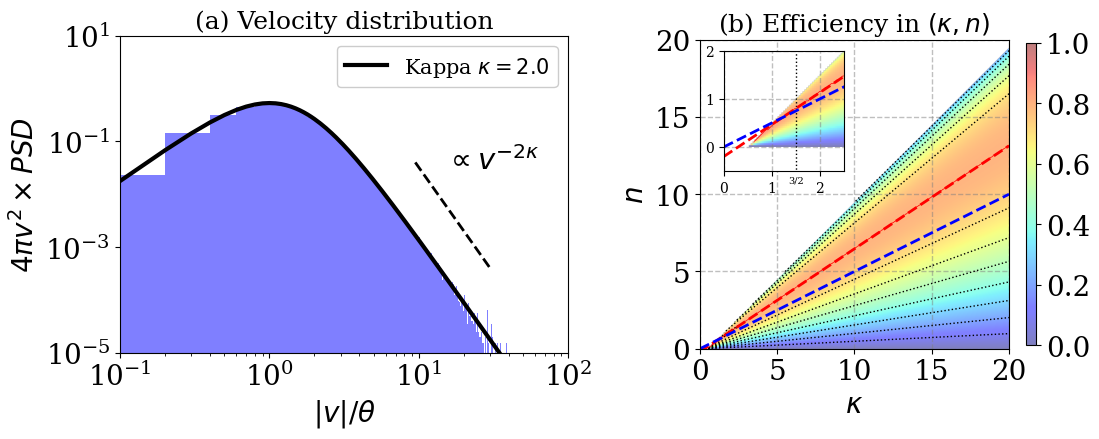

In [5]:
np.random.seed(1227)
mysize=1000000

k  = 2.0
theta = 1.0

if( True ):
    myv, n = gen_kappa43(k,mysize)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.4, 4.8), gridspec_kw={"width_ratios": [4, 3]} )
xx = np.arange(0,100.0,0.1)

ax1.plot( xx, 4*np.pi*xx**2 * kappa(xx,k,1), 'k-', lw=3, label=r"Kappa $\kappa=%3.1f$" % k )
ax1.hist( myv,500,color='blue',range=[0,100],density=True,log=True,alpha=0.5)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.1,20)
ax1.set_xlim(0.1,100)
ax1.set_ylim(1E-5,10)

x = np.logspace(0.5,1.0,3)
ax1.plot( 3*x, 4*x**(-2*k),'k--')
ax1.text(15, 0.03, r"$\propto v^{-2\kappa}$",color='k',fontsize=21)
ax1.legend( loc='upper right', fontsize=15, framealpha=1.0 )
ax1.set_xlabel(r"$|v|/\theta$")
ax1.set_ylabel(r"$4\pi v^2 \times PSD$")
ax1.set_title('(a) Velocity distribution', fontsize=18)

kk = np.linspace(0, 20, num=501)
nn = np.linspace(0, 20, num=501)
kk[0] += 0.00001
nn[0] += 0.00001

opt_map = np.zeros((len(kk),len(nn)))
opt_line = np.zeros_like(kk)

i=0
for n in range(len(nn)):
    opt_map[:,n] = pareto_eff(kk,nn[n])
for k in range(len(kk)):
    opt_line[k] = nn[ opt_map[k,:].argmax() ]
opt_line = np.where( opt_line > 0.1, opt_line, np.nan )
opt_map = np.where( opt_map > 0.0, opt_map, np.nan )

# Kappa distribution (N=1, theta=1)
extent=[0,20,0,20]
myimg = ax2.imshow(opt_map.T,origin='lower',vmin=0,vmax=1,cmap='jet',extent=extent,aspect=1,alpha=0.5)
plt.colorbar( myimg, fraction=0.03, pad=0.05, aspect=30 )
mycnt = ax2.contour(opt_map.T, extent=extent, levels=np.arange(0.0,1.0,0.1), linewidths=1.0, colors='k',linestyles=':')

ax2.plot( kk, opt_line, 'r-', lw=.5 )
ax2.plot( kk, 2/3*kk-1/5, 'r--', lw=2 )
ax2.plot( kk, 1/2*kk    , 'b--', lw=2 )
ax2.grid( linestyle='--', color='gray', lw=1, alpha=0.5)

ax2.set_xlim(0,20)
ax2.set_ylim(0,20)
ax2.set_xticks(np.arange(0, 20.1, 5))
ax2.set_yticks(np.arange(0, 20.1, 5))
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$n$")
ax2.set_title(r"(b) Efficiency in $(\kappa,n)$", fontsize=18)

inlet = plt.axes([ 0.58, 0.6, 0.25, 0.25 ])
inlet.imshow( opt_map.T,origin='lower',vmin=0,vmax=1,cmap='jet',extent=extent,aspect=1,alpha=0.5)
inlet.plot( [1.5, 1.5], [-1, 1e3], 'k:', lw=1 )
inlet.set_xticks(np.arange(0, 3.1, 1))
inlet.set_yticks(np.arange(0, 3.1, 1))
inlet.grid(linestyle='--', color='gray', lw=1, alpha=.5)
inlet.plot( kk, opt_line, 'r-', lw=.5 )
inlet.plot( kk, 2/3*kk-0.2, 'r--', lw=2 )
inlet.plot( kk, 1/2*kk    , 'b--', lw=2 )
inlet.set_xlim(0,2.5)
inlet.set_ylim(-0.5,2)
inlet.set_aspect('equal')
for item in ( inlet.get_xticklabels() + inlet.get_yticklabels()):
    item.set_fontsize(10)
inlet.text( 1.35, -0.75, '3/2', fontsize=7 )

plt.tight_layout()
plt.savefig('fig_KappaPanels3.pdf')
plt.show()